In [330]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [331]:
## SIMULATION PARAMETERS

# Frame width (x axis, dx=1)
Lx = 100
# Frame width (y axis, dy=1)
Ly = 100
# Time Resolution
dt = 1
# Time steps
T = 5000
# Boundary conditions 
"""in order: top, left, bottom, right"""
bc = 'roro' # o = open, r = reflecting

print("Simulation time = ", T*dt, 'sec')

Simulation time =  5000 sec


In [332]:
## STATE VARIABLES (Initialization)

# C1 = density of cooperator (antibiotic resistent)
# C2 = density of cheater (antibiotic sensitive)
# S = concentration of nutrient (glucose)
# A = concentration of antibiotic

## MODEL PARAMETERS

# r1 = max growth rate of cooperator
# r2 = max growth rate of cheater
# Ks = rate of nutrient consumption by Monod kinetics
# Km = Michaelis-Menton rate constant for antibiotic inactivation by cooperator
# IC50 = antibiotic concentration at which cheater growth rate is halved
# Y = biomass yield per unit nutrient
# A0 = antibiotic concentration in feed medium
# S0 = nutrient concentration in feed medium

""" Note: Mesh Fourier number F = D*dt/dx^2 """
""" F < 0.5 to avoid discontinuities in diffusion model with Forward Euler method """

' F < 0.5 to avoid discontinuities in diffusion model with Forward Euler method '

In [333]:
def discrete_laplacian(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4*M
    L += np.roll(M, (0,-1), (0,1)) # right neighbor
    L += np.roll(M, (0,+1), (0,1)) # left neighbor
    L += np.roll(M, (-1,0), (0,1)) # top neighbor
    L += np.roll(M, (+1,0), (0,1)) # bottom neighbor
    
    return L

In [334]:
# Forward Euler (explicit) method

def update_1d(C1, C2, S, A):
    mu_1 = r1*S/(Ks+S)
    mu_2 = r2*S/((Ks+S)*(1+A/IC50))
    C1_diff = mu_1*C1 + DC*discrete_laplacian(C1)
    C2_diff = mu_2*C2 + DC*discrete_laplacian(C2)
    S_diff = -(1/Y)*(mu_1*C1 + mu_2*C2) + DS*discrete_laplacian(S)
    A_diff = -Vmax*np.multiply(A,C1)/(Km+A) + DA*discrete_laplacian(A)
    
    C1+= dt*C1_diff
    C1[C1<0]=0
    C2+= dt*C2_diff
    C2[C2<0]=0
    S+= dt*S_diff
    S[S<0]=0
    A+= dt*A_diff
    A[A<0]=0
    
    #Boundary conditions on left and right
    C1[:,0] = 0
    C1[:,-1] = 0
    C2[:,0] = 0
    C2[:,-1] = 0
    S[:,0] = S0
    S[:,-1] = 0
    A[:,0] = A0
    A[:,-1] = 0
    
    return(C1, C2, S, A)

In [347]:
# Enter Parameters

r1 = 1.2/3600
r2 = 1.32/3600
Ks = 4*10**-6
Km = 18*10**-6
Vmax = 4*10**5/3600
IC50 = 10**-6
Y = 0.5
A0 = 0.004
S0 = 0.004
DC = 0.01
DS = 0.06 #dx=100um
DA = 0.04


In [348]:
# Initialize

C1 = np.zeros((1,Lx+1))
C1[:,30] = 0.04
C2 = np.zeros((1,Lx+1))
C2[:,20] = 0.04
S = np.zeros((1,Lx+1))
S[:,0] = S0
A = np.zeros((1,Lx+1))
A[:,0] = A0

In [349]:
# Run simulation

for tt in range(T):
    C1, C2, S, A = update_1d(C1, C2, S, A)
print('End of simulation')

End of simulation


<IPython.core.display.Javascript object>


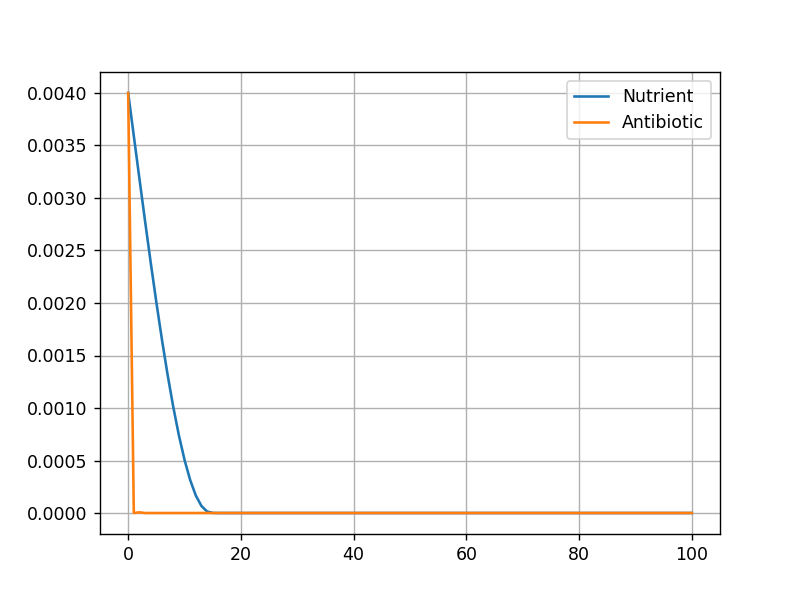

In [350]:
plt.plot(S[0], label='Nutrient')
plt.plot(A[0], label='Antibiotic')
plt.legend()
plt.grid()

<IPython.core.display.Javascript object>


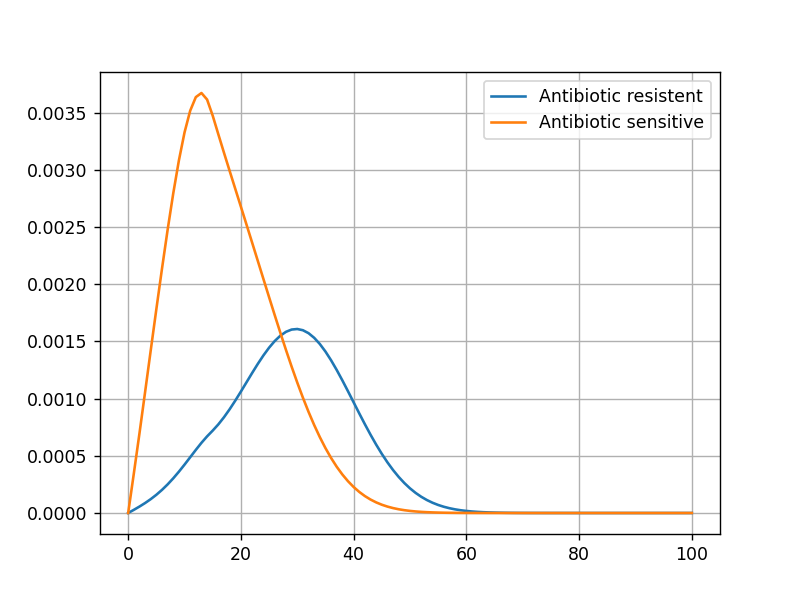

In [351]:
plt.plot(C1[0], label='Antibiotic resistent')
plt.plot(C2[0], label='Antibiotic sensitive')
plt.legend()
plt.grid()